# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import config
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import plotly.express as px

In [354]:
import sqlalchemy
database_username = config.user
database_password = config.password
database_ip       = config.host
database_name     = 'Passengers'
conn = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [673]:
df = pd.read_sql("""SELECT * 
                    FROM Passengers.city_data
                    WHERE year < 2019""", con=conn, index_col='index')

df.head()

ds        city  PASSENGERS           Type  Month  Year  \
index                                                                  
0     2010-01-01     Atlanta     2735491       Domestic      1  2010   
1     2010-01-01  Washington     1929494       Domestic      1  2010   
2     2010-01-01   Singapore     1681005  International      1  2010   
3     2010-01-01      Berlin      489487  International      1  2010   
4     2010-01-01       Paris     4154249  International      1  2010   

       temperature_mean  precipitation  rain_days  pressure  \
index                                                         
0                   3.6          137.0        7.0   1019.50   
1                   0.4           57.0        8.0   1016.70   
2                  27.5           70.0        8.0   1011.60   
3                  -4.9           21.0        7.0   1014.78   
4                   0.6           36.0        7.0   1015.60   

       cost_of_living_index  population  city_ascii      lat       lng  \
index                                                                    
0                    100.99    429193.0     Atlanta  33.7627  -84.4225   
1                     98.19    605085.0  Washington  38.9047  -77.0163   
2                     65.94   5074252.0   Singapore   1.2930  103.8558   
3                    115.24   3450395.0      Berlin  52.5218   13.4015   
4                    130.30  10460118.0       Paris  48.8667    2.3333   

             country iso2 iso3  
index                           
0      United States   US  USA  
1      United States   US  USA  
2          Singapore   SG  SGP  
3            Germany   DE  DEU  
4             France   FR  FRA

### Differencing

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [171]:
total_monthly = pd.DataFrame(df.groupby('ds')['PASSENGERS', 'temperature_mean'].sum())
total_monthly.head()

PASSENGERS  temperature_mean
ds                                      
2010-01-01    65294603             302.6
2010-02-01    61776883             354.1
2010-03-01    75170214             530.4
2010-04-01    71474034             696.7
2010-05-01    76526230             844.0

In [52]:
moving_average = total_monthly.rolling(window=12, min_periods=3).mean()
moving_average.head()

PASSENGERS  temperature_mean
ds                                      
2010-01-01         NaN               NaN
2010-02-01         NaN               NaN
2010-03-01  67413900.0            395.70
2010-04-01  68428933.5            470.95
2010-05-01  70048392.8            545.56

### Moving Average for Destinations

In [350]:
cities = df['city'].unique()
cities

array(['Atlanta', 'Washington', 'Singapore', 'Berlin', 'Paris', 'Dubai',
       'Reykjavik', 'Croatia', 'Athens', 'Hong Kong', 'Seoul', 'Phuket',
       'Amsterdam', 'Taipei', 'Barcelona', 'Rome', 'London', 'Tokyo',
       'Tampa', 'St. Louis', 'Delhi', 'San Francisco', 'Charlotte',
       'Chicago', 'Salt Lake City', 'Portland', 'Phoenix', 'Philadelphia',
       'Orlando', 'Boston', 'New York City', 'Miami', 'Los Angeles',
       'Las Vegas', 'Houston', 'Dallas', 'Denver', 'Honolulu',
       'Minneapolis', 'Seattle', 'Detroit', 'San Diego'], dtype=object)

In [454]:
df_croatia = df[df['city'] == 'Croatia']
df_croatia = df_croatia.rename(columns={'PASSENGERS': 'y'})
df_croatia.head()

ds     city       y           Type  Month  Year  \
index                                                           
7     2010-01-01  Croatia  165000  International      1  2010   
49    2010-02-01  Croatia  145000  International      2  2010   
96    2010-03-01  Croatia  199000  International      3  2010   
138   2010-04-01  Croatia  267000  International      4  2010   
179   2010-05-01  Croatia  492000  International      5  2010   

       temperature_mean  precipitation  rain_days  pressure  \
index                                                         
7                   6.8          140.0       12.0    1011.5   
49                  8.5          164.0       16.0    1006.9   
96                 10.6           69.0        8.0    1016.6   
138                15.4           88.0       10.0    1016.0   
179                18.5           98.0       10.0    1011.1   

       cost_of_living_index  population city_ascii   lat   lng  country iso2  \
index                                                                          
7                      75.6    798966.0    Croatia  45.8  16.0  Croatia   HR   
49                     75.6    798966.0    Croatia  45.8  16.0  Croatia   HR   
96                     75.6    798966.0    Croatia  45.8  16.0  Croatia   HR   
138                    75.6    798966.0    Croatia  45.8  16.0  Croatia   HR   
179                    75.6    798966.0    Croatia  45.8  16.0  Croatia   HR   

      iso3  
index       
7      HRV  
49     HRV  
96     HRV  
138    HRV  
179    HRV

In [631]:
def fit_predict_model(dataframe, interval_width = 0.95, changepoint_range = 0.8):
    m = proph(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                mcmc_samples=1000,
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(df_croatia)

In [632]:
pred.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2010-01-01  404567.570274   80471.688516  187921.979409  378224.266083   
1 2010-02-01  407332.445685   69330.176457  173392.514470  384089.177315   
2 2010-03-01  409829.752508  111763.495011  222537.473484  389485.327881   
3 2010-04-01  412594.627919  244381.206088  351426.455234  394415.586294   
4 2010-05-01  415442.722128  433362.556744  543917.898850  398949.253305   

     trend_upper  multiplicative_terms  multiplicative_terms_lower  \
0  430760.000371             -0.672388                   -0.703665   
1  430720.253944             -0.700107                   -0.730919   
2  430265.913371             -0.591465                   -0.623417   
3  429966.625508             -0.282978                   -0.315314   
4  430825.369076              0.177501                    0.143026   

   multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                   -0.641048 -0.672388     -0.703665     -0.641048   
1                   -0.669026 -0.700107     -0.730919     -0.669026   
2                   -0.559119 -0.591465     -0.623417     -0.559119   
3                   -0.250465 -0.282978     -0.315314     -0.250465   
4                    0.213035  0.177501      0.143026      0.213035   

   additive_terms  additive_terms_lower  additive_terms_upper           yhat  \
0             0.0                   0.0                   0.0  132541.258173   
1             0.0                   0.0                   0.0  122156.311795   
2             0.0                   0.0                   0.0  167429.656415   
3             0.0                   0.0                   0.0  295839.530500   
4             0.0                   0.0                   0.0  489184.367512   

     fact  
0  165000  
1  145000  
2  199000  
3  267000  
4  492000

In [633]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [634]:
pred[pred['anomaly'] == 1]

ds         trend          yhat    yhat_lower    yhat_upper  \
90 2017-07-01  796770.18856  1.684173e+06  1.622296e+06  1.746064e+06   

       fact  anomaly  importance  
90  1750000        1    0.002249

In [635]:
fig = go.Figure()
    
fig.add_trace(go.Scatter(
    x=pred['ds'], y=pred['fact'],
    line_color='rgb(0,100,80)',
    name='Actual'))

fig.add_trace(go.Scatter(
    x=pred['ds'],
    y=pred['yhat_upper'],
    fill="tonexty",
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Predicted Upper'))

fig.add_trace(go.Scatter(
    x=pred['ds'],
    y=pred['yhat_lower'],
    fill="tonexty",
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Predicted Lower'))

size=[]
[size.append(20) for i in range(len(pred[pred['anomaly'] != 0]))]
color = []
[color.append(1) for i in range(len(pred[pred['anomaly'] != 0]))]

fig.add_trace(go.Scatter(x=pred[pred['anomaly'] != 0]['ds'],
                         y=pred[pred['anomaly'] != 0]['fact'], 
                         name="Anomaly", 
                         mode='markers',
                         marker=dict(size=size,
                                    color=color)))

fig.update_layout(title='Croatia Passenger Volume',
                  yaxis_zeroline=False, xaxis_zeroline=False)

fig.show() 

These uncertainty intervals assume that the future will see the same frequency and magnitude of rate changes as the past. By default Prophet will only return uncertainty in the trend and observation noise. To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter mcmc.samples. Bayesian sampling can be used to compute the distribution over the parameters given a set of observations and a prior belief.

In [636]:
def graph_anomalies(city, df):
    df = df[df['city'] == city]
    df = df.rename(columns={'PASSENGERS': 'y'})
    df.head()
    
    m = proph(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                mcmc_samples=1000,
                interval_width = 0.90,
                changepoint_range = 0.8)
    m = m.fit(df)
    forecast = m.predict(df)
    forecast['fact'] = df['y'].reset_index(drop = True)
    
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecasted['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecasted['fact']
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=forecasted['ds'], y=forecasted['fact'],
        line_color='rgb(0,100,80)',
        name='Actual'))

    fig.add_trace(go.Scatter(
        x=forecasted['ds'],
        y=forecasted['yhat_upper'],
        fill="tonexty",
        fillcolor='rgba(0,100,80,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False,
        name='Predicted Upper'))

    fig.add_trace(go.Scatter(
        x=forecasted['ds'],
        y=forecasted['yhat_lower'],
        fill="tonexty",
        fillcolor='rgba(0,100,80,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False,
        name='Predicted Lower'))

    size=[]
    [size.append(20) for i in range(len(forecasted[forecasted['anomaly'] != 0]))]
    color = []
    [color.append(1) for i in range(len(forecasted[forecasted['anomaly'] != 0]))]

    fig.add_trace(go.Scatter(x=forecasted[forecasted['anomaly'] != 0]['ds'],
                             y=forecasted[forecasted['anomaly'] != 0]['fact'], 
                             name="Anomaly", 
                             mode='markers',
                             marker=dict(size=size,
                                        color=color)))

    fig.update_layout(title=f'{city} Passenger Volume',
                      yaxis_zeroline=False, xaxis_zeroline=False)

    fig.show() 
    

In [637]:
graph_anomalies('Reykjavik', df)

In [566]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(pred['fact'], pred['yhat']))
rms

22878.734518753336

In [276]:
size = int(len(total_monthly) * 0.7)
train, test = total_monthly['PASSENGERS'][0:size], total_monthly['PASSENGERS'][size:len(total_monthly)]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


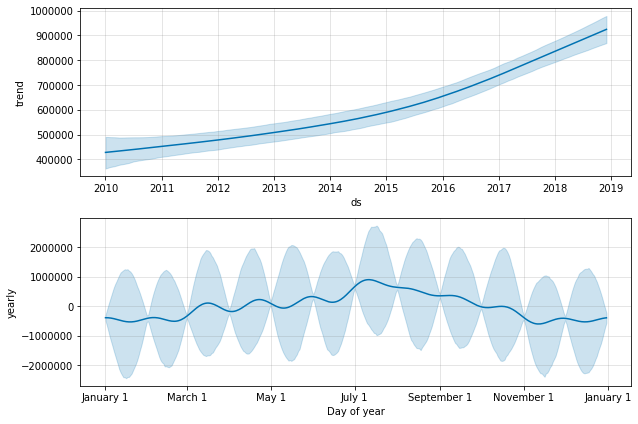

In [578]:
m = proph(mcmc_samples=300)
forecast = m.fit(df_croatia).predict()
fig = m.plot_components(forecast)

In [689]:
# for df_croatia_yearly = pd.DataFrame(df_croatia.groupby('Year')['y'].mean())

all_cities_changes = []


for city in cities:
    for i in range(len(df['Year'].unique())):
        df_city = pd.DataFrame(df[df['city'] == city].groupby('Year')['PASSENGERS'].mean())
        city_dict = {}
        try:
            cy = df_city['PASSENGERS'].iloc[i+1]
            py = df_city['PASSENGERS'].iloc[i]
            city_dict['name'] = city
            city_dict['year'] = 2011 + i
            city_dict['percentage_increase'] = ((cy - py) / py) * 100
        except:
            pass
        all_cities_changes.append(city_dict)

In [695]:
percentage_changes = pd.DataFrame(all_cities_changes)
percentage_changes.dropna(inplace=True)
percentage_changes.head()

name    year  percentage_increase
0  Atlanta  2011.0             2.923014
1  Atlanta  2012.0             3.469309
2  Atlanta  2013.0            -1.404977
3  Atlanta  2014.0             2.705013
4  Atlanta  2015.0             5.987462

In [701]:
px.line(percentage_changes[percentage_changes['percentage_increase'] > 10], x="year", y="percentage_increase", title='Percentage Passenger volume', color='name')


In [696]:
px.line(percentage_changes, x="year", y="percentage_increase", title='Percentage Passenger volume', color='name')

In [699]:
pd.DataFrame(all_cities_changes).head(5)

name    year  percentage_increase
0  Atlanta  2011.0             2.923014
1  Atlanta  2012.0             3.469309
2  Atlanta  2013.0            -1.404977
3  Atlanta  2014.0             2.705013
4  Atlanta  2015.0             5.987462

In [445]:
croatia_rolling = df_croatia.PASSENGERS.rolling(window=12, min_periods=3).mean()
df_croatia _ croatia_rolling.merge()

ds
2010-01-01              NaN
2010-02-01              NaN
2010-03-01    169666.666667
2010-04-01    194000.000000
2010-05-01    253600.000000
                  ...      
2018-08-01    854833.333333
2018-09-01    865416.666667
2018-10-01    873333.333333
2018-11-01    874666.666667
2018-12-01    875666.666667
Name: PASSENGERS, Length: 108, dtype: float64

In [449]:
px.line(croatia_rolling.reset_index(), x="ds", y="PASSENGERS", title='Passenger volume')

In [601]:
df[df['city'] == city][['PASSENGERS', 'ds']].iloc[-6]

PASSENGERS                1129072
ds            2018-07-01 00:00:00
Name: 4401, dtype: object

In [614]:
total_growth = []

for city in cities:
    city_dict = {}
    last_july = df[df['city'] == city]['PASSENGERS'].iloc[-6]
    first_july = df[df['city'] == city]['PASSENGERS'].iloc[6]
    city_dict['name'] = city
    city_dict['percentage_growth'] = ((last_july - first_july) / first_july) * 100
    total_growth.append(city_dict)
    

In [616]:
pd.DataFrame(total_growth)

name  percentage_growth
0          Atlanta          16.855188
1       Washington          13.002043
2        Singapore          60.387899
3           Berlin          76.838030
4            Paris          21.287589
5            Dubai          94.734518
6        Reykjavik         208.129166
7          Croatia         118.350755
8           Athens          96.772414
9        Hong Kong          42.689935
10           Seoul          52.204854
11          Phuket         184.305237
12       Amsterdam          42.626463
13          Taipei          52.154735
14       Barcelona          73.692969
15            Rome          21.242584
16          London          16.499351
17           Tokyo          25.910630
18           Tampa          30.908329
19       St. Louis          24.737993
20           Delhi         168.654910
21   San Francisco          48.344000
22       Charlotte          18.717418
23         Chicago          24.189822
24  Salt Lake City          15.373678
25        Portland          60.347534
26         Phoenix          17.115814
27    Philadelphia           1.608109
28         Orlando          23.132562
29          Boston          29.448512
30   New York City          24.594878
31           Miami          33.624352
32     Los Angeles          31.527791
33       Las Vegas          21.690211
34         Houston          13.868676
35          Dallas          29.364498
36          Denver          19.397622
37        Honolulu           2.948641
38     Minneapolis          13.845992
39         Seattle          51.111883
40         Detroit           6.860464
41       San Diego          39.304411

In [448]:
moving_average = total_monthly.rolling(window=12, min_periods=3).mean()
moving_average.head()

PASSENGERS  temperature_mean  precipitation  cost_of_living_index
ds                                                                           
2010-01-01         NaN               NaN            NaN                   NaN
2010-02-01         NaN               NaN            NaN                   NaN
2010-03-01  67413900.0            395.70    3223.666667                3797.5
2010-04-01  68428933.5            470.95    3194.750000                3797.5
2010-05-01  70048392.8            545.56    3221.900000                3797.5

In [53]:
total_monthly

PASSENGERS  temperature_mean
ds                                      
2010-01-01    65294603             302.6
2010-02-01    61776883             354.1
2010-03-01    75170214             530.4
2010-04-01    71474034             696.7
2010-05-01    76526230             844.0
...                ...               ...
2018-08-01   116312494            1086.5
2018-09-01   102816594             976.5
2018-10-01   106973274             752.1
2018-11-01    98851172             525.6
2018-12-01    99919145             422.4

[108 rows x 2 columns]

In [54]:
data_diff = data_minus_exp_roll_mean.diff(periods=12)

In [55]:
data_diff

PASSENGERS  temperature_mean
ds                                         
2010-01-01            NaN               NaN
2010-02-01            NaN               NaN
2010-03-01            NaN               NaN
2010-04-01            NaN               NaN
2010-05-01            NaN               NaN
...                   ...               ...
2018-08-01  156949.797250         24.119680
2018-09-01 -598896.252507          6.519298
2018-10-01 -866959.761332        -39.655044
2018-11-01 -828964.445345        -29.171722
2018-12-01 -861055.556066         43.294931

[108 rows x 2 columns]

In [56]:
data_diff.reset_index(inplace=True)

In [66]:
data_remove_trend = total_monthly - moving_average
data_remove_trend.head()

PASSENGERS  temperature_mean
ds                                      
2010-01-01         NaN               NaN
2010-02-01         NaN               NaN
2010-03-01   7756314.0            134.70
2010-04-01   3045100.5            225.75
2010-05-01   6477837.2            298.44

In [67]:
# Drop the missing values from time series calculated above
data_remove_trend.dropna(inplace=True)

In [68]:
px.line(data_remove_trend.reset_index(), 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using MA'
        )

We'll take the difference of one year/12 months from the data because of the annual seasonality observed.

In [69]:
data_diff = data_remove_trend.diff(periods=12)

In [70]:
data_diff

PASSENGERS  temperature_mean
ds                                        
2010-03-01           NaN               NaN
2010-04-01           NaN               NaN
2010-05-01           NaN               NaN
2010-06-01           NaN               NaN
2010-07-01           NaN               NaN
...                  ...               ...
2018-08-01  8.205212e+05         45.497407
2018-09-01 -4.370781e+05         27.180741
2018-10-01 -9.690770e+05        -31.510926
2018-11-01 -1.138288e+06        -31.710926
2018-12-01 -1.459386e+06         52.314074

[106 rows x 2 columns]

In [71]:
data_diff.reset_index(inplace=True)

In [72]:
data_diff

ds    PASSENGERS  temperature_mean
0   2010-03-01           NaN               NaN
1   2010-04-01           NaN               NaN
2   2010-05-01           NaN               NaN
3   2010-06-01           NaN               NaN
4   2010-07-01           NaN               NaN
..         ...           ...               ...
101 2018-08-01  8.205212e+05         45.497407
102 2018-09-01 -4.370781e+05         27.180741
103 2018-10-01 -9.690770e+05        -31.510926
104 2018-11-01 -1.138288e+06        -31.710926
105 2018-12-01 -1.459386e+06         52.314074

[106 rows x 3 columns]

In [73]:
px.line(data_diff, 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using MA + Differencing'
        )

## Decomposition

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



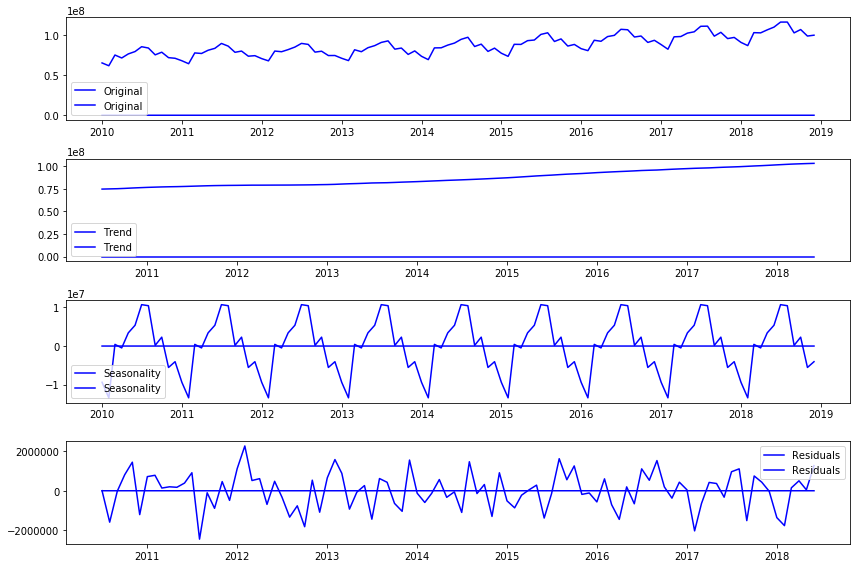

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(total_monthly)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(total_monthly, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

## ACF & PACF

In [28]:
total_monthly

PASSENGERS  temperature_mean
ds                                      
2010-01-01    65294603             302.6
2010-02-01    61776883             354.1
2010-03-01    75170214             530.4
2010-04-01    71474034             696.7
2010-05-01    76526230             844.0
...                ...               ...
2018-08-01   116312494            1086.5
2018-09-01   102816594             976.5
2018-10-01   106973274             752.1
2018-11-01    98851172             525.6
2018-12-01    99919145             422.4

[108 rows x 2 columns]

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



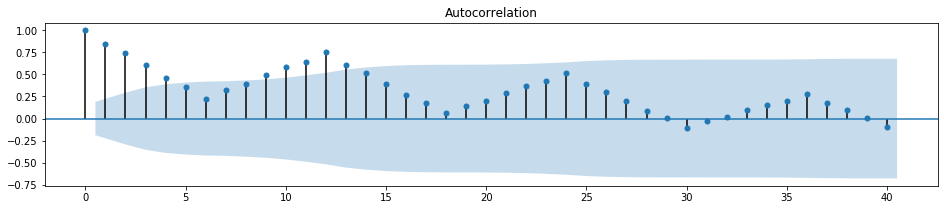

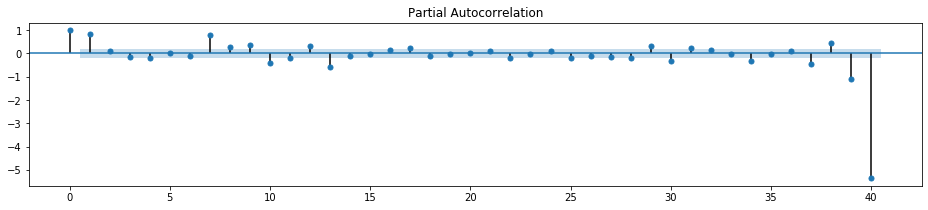

In [29]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(total_monthly['PASSENGERS'],ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(total_monthly['PASSENGERS'],ax=ax, lags=40);

### Dickey-Fuller Test

In [50]:
def stationarity_check(df):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = df.rolling(window = 8, center = False).mean()
    rolstd = df.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df['PASSENGERS']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

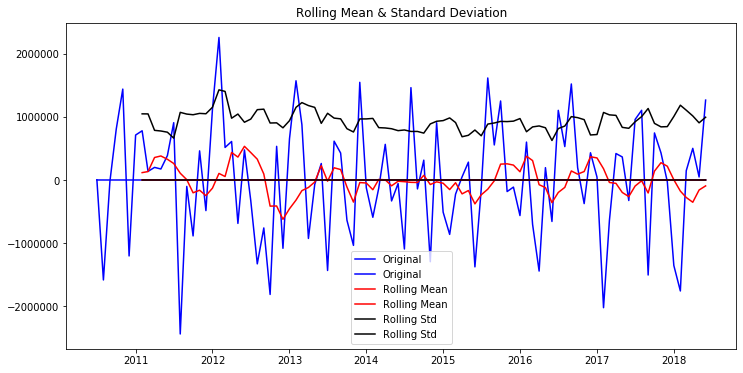

Results of Dickey-Fuller Test:
Test Statistic                 -3.687110
p-value                         0.004298
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [51]:
df_log_decompose = residual
df_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(df_log_decompose)

The Dickey-Fuller test tests the null hypothesis that the data is not stationary. Therefore, a low p-value <0.01 means we can reject the null hypothesis and be very confident that our data is stationary.

## ARMA

In [34]:
# Fit an AR(1) model to the first simulated data
mod_arma = ARMA(total_monthly['PASSENGERS'], order=(1,6))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                              ARMA Model Results                              
Dep. Variable:             PASSENGERS   No. Observations:                  108
Model:                     ARMA(1, 6)   Log Likelihood               -1808.481
Method:                       css-mle   S.D. of innovations        4310574.329
Date:                Fri, 17 Jan 2020   AIC                           3634.962
Time:                        10:13:10   BIC                           3659.101
Sample:                    01-01-2010   HQIC                          3644.750
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.735e+07   9.99e+06      8.746      0.000    6.78e+07    1.07e+08
ar.L1.PASSENGERS     0.9904      0.014     71.740      0.000       0.963       1.017
ma.L1.PASSENGERS    -0.3652 

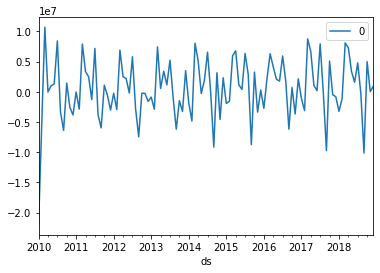

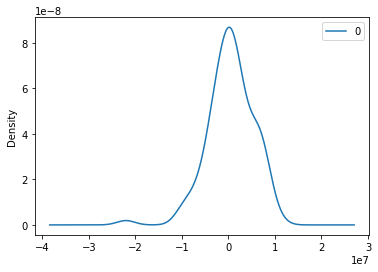

                  0
count  1.080000e+02
mean   4.880480e+05
std    4.925915e+06
min   -2.205391e+07
25%   -2.632568e+06
50%    3.283527e+05
75%    3.383461e+06
max    1.067925e+07


In [35]:
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## SARIMAX on Average Passengers Across all Destinations

In [275]:
total_monthly.head()

PASSENGERS  temperature_mean
ds                                      
2010-01-01    65294603             302.6
2010-02-01    61776883             354.1
2010-03-01    75170214             530.4
2010-04-01    71474034             696.7
2010-05-01    76526230             844.0

In [276]:
size = int(len(total_monthly) * 0.7)
train, test = total_monthly['PASSENGERS'][0:size], total_monthly['PASSENGERS'][size:len(total_monthly)]

In [277]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,order=(0, 1, 0),seasonal_order=(0,1,0,12))
results = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [278]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                   75
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -969.198
Date:                            Fri, 17 Jan 2020   AIC                           1940.396
Time:                                    15:31:59   BIC                           1942.523
Sample:                                01-01-2010   HQIC                          1941.231
                                     - 03-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.797e+12   2.53e+11      7.113      0.000     1.3e+12    2.29e+12
===================================================================================
Ljung-Box (Q):                       65.72   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.01   Prob(JB):                         0.40
Heteroskedasticity (H):               0.84   Skew:                             0.41
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [279]:
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 1, 0)(0,1,0,12) Predictions')


In [280]:
predictions

2016-04-01     93484511.0
2016-05-01     98170366.0
2016-06-01     98956399.0
2016-07-01    105959339.0
2016-08-01    107982881.0
2016-09-01     97142855.0
2016-10-01    100338649.0
2016-11-01     91418379.0
2016-12-01     93444297.0
2017-01-01     88164303.0
2017-02-01     85712140.0
2017-03-01     98670547.0
2017-04-01     98554484.0
2017-05-01    103240339.0
2017-06-01    104026372.0
2017-07-01    111029312.0
2017-08-01    113052854.0
2017-09-01    102212828.0
2017-10-01    105408622.0
2017-11-01     96488352.0
2017-12-01     98514270.0
2018-01-01     93234276.0
2018-02-01     90782113.0
2018-03-01    103740520.0
2018-04-01    103624457.0
2018-05-01    108310312.0
2018-06-01    109096345.0
2018-07-01    116099285.0
2018-08-01    118122827.0
2018-09-01    107282801.0
2018-10-01    110478595.0
2018-11-01    101558325.0
2018-12-01    103584243.0
Freq: MS, Name: SARIMA(0, 1, 0)(0,1,0,12) Predictions, dtype: float64

In [299]:
total_monthly['PASSENGERS']

ds
2010-01-01     65294603
2010-02-01     61776883
2010-03-01     75170214
2010-04-01     71474034
2010-05-01     76526230
                ...    
2018-08-01    116312494
2018-09-01    102816594
2018-10-01    106973274
2018-11-01     98851172
2018-12-01     99919145
Name: PASSENGERS, Length: 108, dtype: int64

In [301]:
pd.plotting.register_matplotlib_converters()

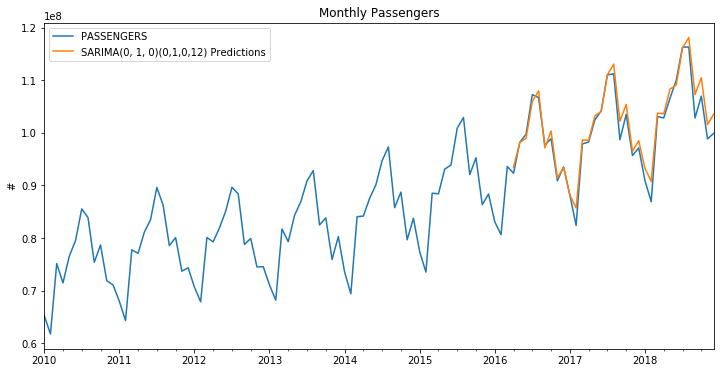

In [302]:
# Plot predictions against known values
title = 'Monthly Passengers'
ylabel='#'
xlabel=''

ax = total_monthly['PASSENGERS'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [306]:
actual = total_monthly['PASSENGERS'][start:end+1]

In [307]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(actual, predictions))
rms

1934568.2883898125

## SARIMAX with Exogenous Variables

In [316]:
total_monthly = pd.DataFrame(df.groupby('ds')['PASSENGERS', 'temperature_mean', 'precipitation', 'cost_of_living_index'].sum())

In [317]:
size = int(len(total_monthly) * 0.7)
train_exog, test_exog = total_monthly[0:size], total_monthly[size:len(total_monthly)]

In [318]:
train_exog

PASSENGERS  temperature_mean  precipitation  cost_of_living_index
ds                                                                           
2010-01-01    65294603             302.6    2835.000000               3797.50
2010-02-01    61776883             354.1    2839.000000               3797.50
2010-03-01    75170214             530.4    3997.000000               3797.50
2010-04-01    71474034             696.7    3108.000000               3797.50
2010-05-01    76526230             844.0    3330.500000               3797.50
...                ...               ...            ...                   ...
2015-11-01    86348406             599.9    3917.000000               3451.73
2015-12-01    88374324             501.5    4364.500000               3451.73
2016-01-01    83094330             348.1    3195.000000               3296.22
2016-02-01    80642167             434.1    2821.111111               3296.22
2016-03-01    93600574             584.6    2477.000000               3296.22

[75 rows x 4 columns]

In [319]:
# Variables
endog = train_exog['PASSENGERS']
exog = train_exog[['temperature_mean', 'precipitation', 'cost_of_living_index']]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,0,0,1))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:             PASSENGERS   No. Observations:                   75
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1267.292
Date:                Fri, 17 Jan 2020   AIC                           2544.583
Time:                        15:57:16   BIC                           2556.171
Sample:                    01-01-2010   HQIC                          2549.210
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
temperature_mean      1.789e+04   5544.302      3.226      0.001    7019.738    2.88e+04
precipitation         2975.7134    936.248      3.178      0.001    1140.702    4810.725
cost_of_livi

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [323]:
start=len(train_exog)
end=len(train_exog)+len(test_exog)-1

exog_forecast = test_exog[['temperature_mean', 'precipitation', 'cost_of_living_index']]

predictions = res.predict(start=start, end=end, exog=exog_forecast, dynamic=False, typ='levels').rename('SARIMA(0, 1, 0)(0,1,0,12) Predictions')


In [324]:
predictions

2016-04-01    9.133009e+07
2016-05-01    9.544768e+07
2016-06-01    9.526876e+07
2016-07-01    9.264325e+07
2016-08-01    9.391497e+07
2016-09-01    8.805314e+07
2016-10-01    8.312692e+07
2016-11-01    7.596198e+07
2016-12-01    7.046182e+07
2017-01-01    7.297828e+07
2017-02-01    7.161181e+07
2017-03-01    7.414579e+07
2017-04-01    7.871255e+07
2017-05-01    8.000753e+07
2017-06-01    8.414029e+07
2017-07-01    8.614805e+07
2017-08-01    8.787568e+07
2017-09-01    8.146190e+07
2017-10-01    7.977033e+07
2017-11-01    7.027938e+07
2017-12-01    6.689571e+07
2018-01-01    6.890408e+07
2018-02-01    7.064731e+07
2018-03-01    7.171148e+07
2018-04-01    7.504131e+07
2018-05-01    8.265667e+07
2018-06-01    8.437836e+07
2018-07-01    8.592779e+07
2018-08-01    8.564675e+07
2018-09-01    8.443020e+07
2018-10-01    7.846581e+07
2018-11-01    7.464651e+07
2018-12-01    7.290136e+07
Freq: MS, Name: SARIMA(0, 1, 0)(0,1,0,12) Predictions, dtype: float64

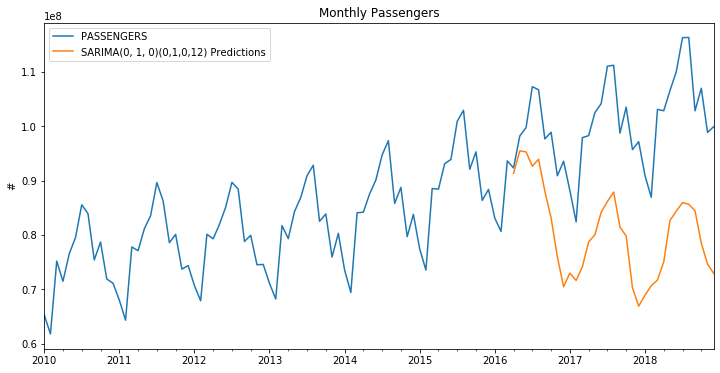

In [325]:
# Plot predictions against known values
title = 'Monthly Passengers'
ylabel='#'
xlabel=''

ax = total_monthly['PASSENGERS'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [326]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(actual, predictions))
rms

21564520.759511266

### Fit NYC model

In [338]:
size = int(len(nycdf) * 0.7)
nyctrain, nyctest = nycdf['PASSENGERS'][0:size], nycdf['PASSENGERS'][size:len(nycdf)]

In [340]:
# Variables
endog = nyctrain
# exog = nycdf[['temperature_mean', 'precipitation']]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, order=(1,0,0,1))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:             PASSENGERS   No. Observations:                   75
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1057.442
Date:                Fri, 17 Jan 2020   AIC                           2118.883
Time:                        16:01:55   BIC                           2123.518
Sample:                    01-01-2010   HQIC                          2120.734
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9952      0.011     86.951      0.000       0.973       1.018
sigma2      9.731e+10   3.81e-15   2.55e+25      0.000    9.73e+10    9.73e+10
Ljung-Box (Q):                      241.98   Jarque-

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [341]:
start=len(nyctrain)
end=len(nyctrain)+len(nyctest)-1

predictions = res.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 1, 0)(0,1,0,12) Predictions')



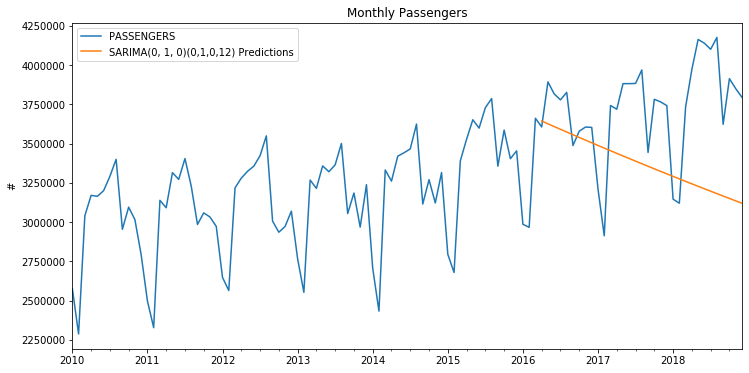

In [344]:
# Plot predictions against known values
title = 'Monthly Passengers'
ylabel='#'
xlabel=''

ax = nycdf['PASSENGERS'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Prophet

In [123]:
from fbprophet import Prophet as proph


In [203]:
prophetdf = pd.DataFrame(df[['PASSENGERS', 'ds']])
prophetdf

PASSENGERS         ds
index                       
0         2735491 2010-01-01
1         1929494 2010-01-01
2         1681005 2010-01-01
3          489487 2010-01-01
4         4154249 2010-01-01
...           ...        ...
4639      1728205 2018-12-01
4640      3794306 2018-12-01
4641      1295947 2018-12-01
4642      3491734 2018-12-01
4643      2267294 2018-12-01

[4644 rows x 2 columns]

In [204]:
prophetdf = prophetdf.rename(columns={'PASSENGERS': 'y'})
prophetdf

y         ds
index                    
0      2735491 2010-01-01
1      1929494 2010-01-01
2      1681005 2010-01-01
3       489487 2010-01-01
4      4154249 2010-01-01
...        ...        ...
4639   1728205 2018-12-01
4640   3794306 2018-12-01
4641   1295947 2018-12-01
4642   3491734 2018-12-01
4643   2267294 2018-12-01

[4644 rows x 2 columns]

In [205]:
Model = proph(interval_width=0.95)

In [206]:
Model.fit(prophetdf)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [207]:
# USe make_future_dataframe with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=36, freq='MS')

In [208]:
forecast = Model.predict(future_dates)
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2010-01-01  1.710662e+06 -1.602735e+06  4.330384e+06  1.710662e+06   
1 2010-01-01  1.710662e+06 -1.270256e+06  4.095890e+06  1.710662e+06   
2 2010-01-01  1.710662e+06 -1.381013e+06  4.326941e+06  1.710662e+06   
3 2010-01-01  1.710662e+06 -1.559808e+06  4.369318e+06  1.710662e+06   
4 2010-01-01  1.710662e+06 -1.326276e+06  4.253804e+06  1.710662e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  1.710662e+06  -222732.273051        -222732.273051        -222732.273051   
1  1.710662e+06  -222732.273051        -222732.273051        -222732.273051   
2  1.710662e+06  -222732.273051        -222732.273051        -222732.273051   
3  1.710662e+06  -222732.273051        -222732.273051        -222732.273051   
4  1.710662e+06  -222732.273051        -222732.273051        -222732.273051   

          yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0 -222732.273051 -222732.273051 -222732.273051                   0.0   
1 -222732.273051 -222732.273051 -222732.273051                   0.0   
2 -222732.273051 -222732.273051 -222732.273051                   0.0   
3 -222732.273051 -222732.273051 -222732.273051                   0.0   
4 -222732.273051 -222732.273051 -222732.273051                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  1.487930e+06  
1                         0.0                         0.0  1.487930e+06  
2                         0.0                         0.0  1.487930e+06  
3                         0.0                         0.0  1.487930e+06  
4                         0.0                         0.0  1.487930e+06

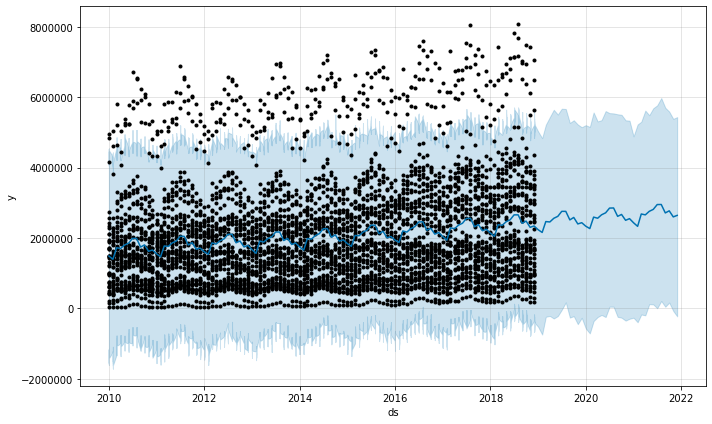

In [209]:
Model.plot(forecast, uncertainty=True)
plt.show()

In [238]:
total_monthly_prophet = total_monthly[['PASSENGERS']]
total_monthly_prophet = total_monthly_prophet.rename(columns={'PASSENGERS': 'y'})
total_monthly_prophet

y
ds                   
2010-01-01   65294603
2010-02-01   61776883
2010-03-01   75170214
2010-04-01   71474034
2010-05-01   76526230
...               ...
2018-08-01  116312494
2018-09-01  102816594
2018-10-01  106973274
2018-11-01   98851172
2018-12-01   99919145

[108 rows x 1 columns]

In [245]:
size = int(len(total_monthly_prophet) * 0.7)
train, test = pd.DataFrame(total_monthly_prophet['y'][0:size]), pd.DataFrame(total_monthly_prophet['y'][size:len(total_monthly_prophet)])

In [247]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [248]:
start=len(train)
end=len(train)+len(test)-1

In [250]:
future_dates

ds
0    2010-01-01
1    2010-01-01
2    2010-01-01
3    2010-01-01
4    2010-01-01
...         ...
4675 2021-08-01
4676 2021-09-01
4677 2021-10-01
4678 2021-11-01
4679 2021-12-01

[4680 rows x 1 columns]

In [254]:
total_monthly_prophet.reset_index(inplace=True)

In [245]:
size = int(len(total_monthly_prophet) * 0.7)
train, test = pd.DataFrame(total_monthly_prophet['y'][0:size]), pd.DataFrame(total_monthly_prophet['y'][size:len(total_monthly_prophet)])

In [247]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [248]:
start=len(train)
end=len(train)+len(test)-1

In [250]:
future_dates

ds
0    2010-01-01
1    2010-01-01
2    2010-01-01
3    2010-01-01
4    2010-01-01
...         ...
4675 2021-08-01
4676 2021-09-01
4677 2021-10-01
4678 2021-11-01
4679 2021-12-01

[4680 rows x 1 columns]

In [254]:
total_monthly_prophet.reset_index(inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


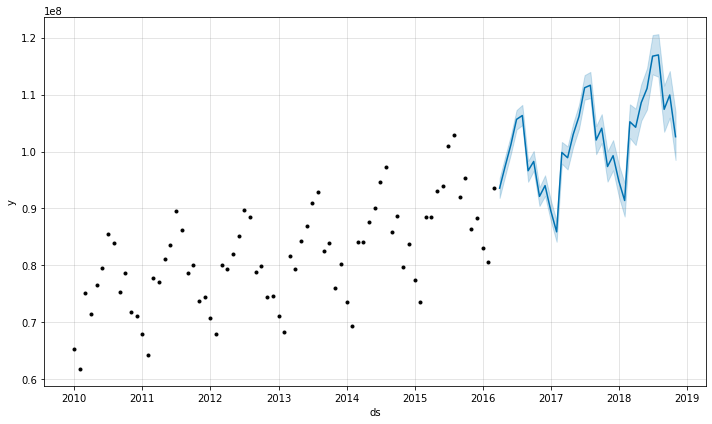

In [259]:
Model = proph(interval_width=0.95)
Model.fit(train)
forecast = Model.predict(pd.DataFrame(total_monthly_prophet['ds'][start:end]))
forecast.head()
Model.plot(forecast, uncertainty=True)
plt.show()

In [261]:
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2016-04-01  9.416270e+07  9.184297e+07  9.527053e+07  9.414065e+07   
1 2016-05-01  9.460565e+07  9.572248e+07  9.910280e+07  9.453430e+07   
2 2016-06-01  9.506336e+07  9.962342e+07  1.028940e+08  9.494076e+07   
3 2016-07-01  9.550631e+07  1.038569e+08  1.072838e+08  9.531591e+07   
4 2016-08-01  9.596402e+07  1.046302e+08  1.081974e+08  9.569940e+07   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  9.418382e+07   -6.059101e+05         -6.059101e+05         -6.059101e+05   
1  9.466480e+07    2.811084e+06          2.811084e+06          2.811084e+06   
2  9.517697e+07    6.182753e+06          6.182753e+06          6.182753e+06   
3  9.568370e+07    1.014417e+07          1.014417e+07          1.014417e+07   
4  9.621797e+07    1.035581e+07          1.035581e+07          1.035581e+07   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 -6.059101e+05 -6.059101e+05 -6.059101e+05                   0.0   
1  2.811084e+06  2.811084e+06  2.811084e+06                   0.0   
2  6.182753e+06  6.182753e+06  6.182753e+06                   0.0   
3  1.014417e+07  1.014417e+07  1.014417e+07                   0.0   
4  1.035581e+07  1.035581e+07  1.035581e+07                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  9.355679e+07  
1                         0.0                         0.0  9.741673e+07  
2                         0.0                         0.0  1.012461e+08  
3                         0.0                         0.0  1.056505e+08  
4                         0.0                         0.0  1.063198e+08

In [268]:
df_actual = total_monthly_prophet['y'][start:end]
df_actual

75      92320712
76      98201479
77      99728767
78     107259181
79     106698734
80      97655972
81      98880751
82      90877498
83      93545085
84      88161399
85      82397653
86      97885037
87      98258214
88     102499278
89     104134626
90     111026712
91     111206172
92      98714189
93     103498039
94      95681310
95      97138035
96      90935020
97      86923482
98     103085916
99     102832106
100    106558160
101    110000131
102    116279124
103    116312494
104    102816594
105    106973274
106     98851172
Name: y, dtype: int64

In [269]:
forecast.loc[:, 'yhat']

0     9.355679e+07
1     9.741673e+07
2     1.012461e+08
3     1.056505e+08
4     1.063198e+08
5     9.662190e+07
6     9.825576e+07
7     9.210889e+07
8     9.400578e+07
9     8.955319e+07
10    8.588538e+07
11    9.982886e+07
12    9.890738e+07
13    1.030082e+08
14    1.061595e+08
15    1.111992e+08
16    1.116440e+08
17    1.020140e+08
18    1.040933e+08
19    9.735974e+07
20    9.926362e+07
21    9.478301e+07
22    9.138889e+07
23    1.052208e+08
24    1.042586e+08
25    1.085932e+08
26    1.110718e+08
27    1.167520e+08
28    1.169677e+08
29    1.074146e+08
30    1.099261e+08
31    1.026030e+08
Name: yhat, dtype: float64

In [274]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(df_actual, forecast.loc[:, 'yhat']))
rms

2114279.5365915042

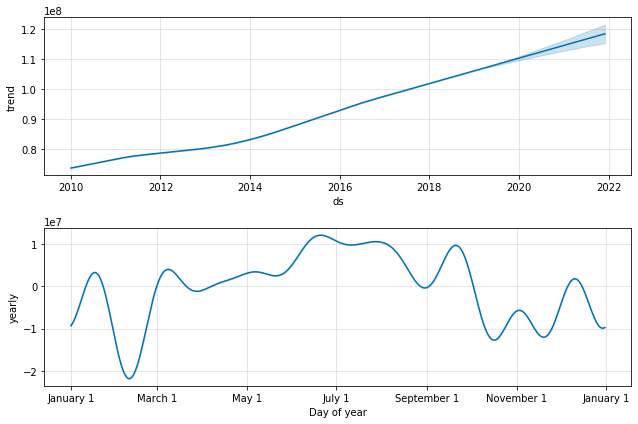

In [223]:
Model.plot_components(forecast)
plt.show()

In [224]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(Model, forecast)  # This returns a plotly Figure
py.iplot(fig)

## Panel Data Model

In [226]:
!pip install linearmodels

     |████████████████████████████████| 1.4MB 16.0MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 12.3MB/s eta 0:00:01
  Found existing installation: Cython 0.29.13
    Uninstalling Cython-0.29.13:
      Successfully uninstalled Cython-0.29.13


In [369]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [362]:
from linearmodels.datasets import jobtraining
data = jobtraining.load()
data

year   fcode  employ       sales   avgsal  scrap  rework  tothrs  union  \
0    1987  410032   100.0  47000000.0  35000.0    NaN     NaN    12.0      0   
1    1988  410032   131.0  43000000.0  37000.0    NaN     NaN     8.0      0   
2    1989  410032   123.0  49000000.0  39000.0    NaN     NaN     8.0      0   
3    1987  410440    12.0   1560000.0  10500.0    NaN     NaN    12.0      0   
4    1988  410440    13.0   1970000.0  11000.0    NaN     NaN    12.0      0   
..    ...     ...     ...         ...      ...    ...     ...     ...    ...   
466  1988  419483   108.0  11500000.0  14810.0   25.0     NaN     0.0      1   
467  1989  419483   129.0  12000000.0  14227.0   30.0     NaN    20.0      1   
468  1987  419486    80.0   7000000.0  16000.0    NaN     NaN     0.0      0   
469  1988  419486    90.0   8500000.0  17000.0    NaN     NaN     0.0      0   
470  1989  419486   100.0   9900000.0  18000.0    NaN     NaN    40.0      0   

     grant  ...  grant_1   clscrap  cgrant  clemploy   clsales    lavgsal  \
0        0  ...        0       NaN       0       NaN       NaN  10.463100   
1        0  ...        0       NaN       0  0.270027 -0.088949  10.518670   
2        0  ...        0       NaN       0 -0.063013  0.130621  10.571320   
3        0  ...        0       NaN       0       NaN       NaN   9.259130   
4        0  ...        0       NaN       0  0.080043  0.233347   9.305651   
..     ...  ...      ...       ...     ...       ...       ...        ...   
466      0  ...        0  0.223144       0 -0.208218  0.044453   9.603058   
467      0  ...        0  0.182321       0  0.177681  0.042559   9.562897   
468      0  ...        0       NaN       0       NaN       NaN   9.680344   
469      0  ...        0       NaN       0  0.117783  0.194157   9.740969   
470      1  ...        0       NaN       1  0.105360  0.152469   9.798127   

     clavgsal  cgrant_1    chrsemp  clhrsemp  
0         NaN       NaN        NaN       NaN  
1    0.055570       0.0  -8.946565 -1.165385  
2    0.052644       0.0   0.198597  0.047832  
3         NaN       NaN        NaN       NaN  
4    0.046520       0.0   0.000000  0.000000  
..        ...       ...        ...       ...  
466  0.059321       0.0   0.000000  0.000000  
467 -0.040161       0.0   3.100775  1.411176  
468       NaN       NaN        NaN       NaN  
469  0.060625       0.0   0.000000  0.000000  
470  0.057159       0.0  36.000000  3.610918  

[471 rows x 30 columns]

In [372]:
df_timeindex = df.set_index(['city', 'ds'])

In [389]:
cities

array(['Atlanta', 'Washington', 'Singapore', 'Berlin', 'Paris', 'Dubai',
       'Reykjavik', 'Croatia', 'Athens', 'Hong Kong', 'Seoul', 'Phuket',
       'Amsterdam', 'Taipei', 'Barcelona', 'Rome', 'London', 'Tokyo',
       'Tampa', 'St. Louis', 'Delhi', 'San Francisco', 'Charlotte',
       'Chicago', 'Salt Lake City', 'Portland', 'Phoenix', 'Philadelphia',
       'Orlando', 'Boston', 'New York City', 'Miami', 'Los Angeles',
       'Las Vegas', 'Houston', 'Dallas', 'Denver', 'Honolulu',
       'Minneapolis', 'Seattle', 'Detroit', 'San Diego'], dtype=object)

In [393]:
for city in cities:
    print(city, len(df[df['city']==city]))

Atlanta 108
Washington 108
Singapore 108
Berlin 108
Paris 108
Dubai 108
Reykjavik 108
Croatia 108
Athens 108
Hong Kong 108
Seoul 108
Phuket 108
Amsterdam 108
Taipei 108
Barcelona 108
Rome 108
London 108
Tokyo 108
Tampa 108
St. Louis 108
Delhi 108
San Francisco 108
Charlotte 108
Chicago 108
Salt Lake City 108
Portland 216
Phoenix 108
Philadelphia 108
Orlando 108
Boston 108
New York City 108
Miami 108
Los Angeles 108
Las Vegas 108
Houston 108
Dallas 108
Denver 108
Honolulu 108
Minneapolis 108
Seattle 108
Detroit 108
San Diego 108


In [419]:
exog_vars = ['population','cost_of_living_index', 'temperature_mean', 'precipitation']
exog = sm.add_constant(df_timeindex[exog_vars])

mod = PanelOLS(df_timeindex.PASSENGERS, exog=exog, time_effects=True)

In [421]:
re_res = mod.fit()
print(re_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             PASSENGERS   R-squared:                        0.4732
Estimator:                   PanelOLS   R-squared (Between):              0.5219
No. Observations:                4644   R-squared (Within):              -0.6381
Date:                Tue, Jan 21 2020   R-squared (Overall):              0.4319
Time:                        10:47:06   Log-likelihood                -7.093e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1017.8
Entities:                          42   P-value                           0.0000
Avg Obs:                       110.57   Distribution:                  F(4,4532)
Min Obs:                       108.00                                           
Max Obs:                       216.00   F-statistic (robust):             1017.8
                            

In [422]:
ypred = re_res.predict()
print(ypred)

                          fitted_values
city          ds                       
Atlanta       2010-01-01   1.811889e+06
Washington    2010-01-01   1.803959e+06
Singapore     2010-01-01   1.875511e+06
Berlin        2010-01-01   2.662880e+06
Paris         2010-01-01   4.137085e+06
...                                 ...
Las Vegas     2018-12-01   1.054445e+06
New York City 2018-12-01   2.804154e+06
Minneapolis   2018-12-01   1.220936e+06
Los Angeles   2018-12-01   2.052779e+06
Miami         2018-12-01   1.831540e+06

[4644 rows x 1 columns]


In [431]:
preds = pd.DataFrame(ypred).reset_index()
preds.set_index('ds', inplace=True)
preds

city  fitted_values
ds                                      
2010-01-01        Atlanta   1.811889e+06
2010-01-01     Washington   1.803959e+06
2010-01-01      Singapore   1.875511e+06
2010-01-01         Berlin   2.662880e+06
2010-01-01          Paris   4.137085e+06
...                   ...            ...
2018-12-01      Las Vegas   1.054445e+06
2018-12-01  New York City   2.804154e+06
2018-12-01    Minneapolis   1.220936e+06
2018-12-01    Los Angeles   2.052779e+06
2018-12-01          Miami   1.831540e+06

[4644 rows x 2 columns]